In [1]:
from glob import glob
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import cohen_kappa_score, jaccard_similarity_score
%matplotlib inline

In [2]:
import nibabel as nib
from nibabel.streamlines import load as load_trk
import dipy.tracking.streamline as dts
import dipy.tracking.utils as dtu
from skimage.transform import resize
from scipy.ndimage.morphology import binary_dilation
import dipy.data as dpd

In [3]:
import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LeakyReLU
from keras.layers import Conv2D, MaxPooling2D

Using TensorFlow backend.


In [4]:
import bundlenet as bn

In [5]:
dpd.fetch_bundles_2_subjects()

Data size is approximately 234MB
Dataset is already in place. If you want to fetch it again please first remove the folder /Users/jpowen/.dipy/exp_bundles_and_maps 


({'bundles_2_subjects.tar.gz': ('https://digital.lib.washington.edu/researchworks/bitstream/handle/1773/38477/bundles_2_subjects.tar.gz',
   '97756fbef11ce2df31f1bedf1fc7aac7')},
 '/Users/jpowen/.dipy/exp_bundles_and_maps')

In [6]:
ls /Users/jpowen/.dipy/exp_bundles_and_maps/bundles_2_subjects/subj_1/bundles/

bundles_af.left.trk      bundles_cg.left.trk      bundles_mdlf.right.trk
bundles_af.right.trk     bundles_cg.right.trk     bundles_slf1.left.trk
bundles_cc_1.trk         bundles_cst.left.trk     bundles_slf1.right.trk
bundles_cc_2.trk         bundles_cst.right.trk    bundles_slf2.left.trk
bundles_cc_3.trk         bundles_ifof.left.trk    bundles_slf2.right.trk
bundles_cc_4.trk         bundles_ifof.right.trk   bundles_slf_3.left.trk
bundles_cc_5.trk         bundles_ilf.left.trk     bundles_slf_3.right.trk
bundles_cc_6.trk         bundles_ilf.right.trk    bundles_uf.left.trk
bundles_cc_7.trk         bundles_mdlf.left.trk    bundles_uf.right.trk


In [7]:
bundle_files = glob('/Users/jpowen/.dipy/exp_bundles_and_maps/bundles_2_subjects/subj_1/bundles/*.trk')

In [8]:
t1_img = nib.load('/Users/jpowen/.dipy/exp_bundles_and_maps/bundles_2_subjects/subj_1/t1_warped.nii.gz')

In [9]:
n_streamlines = []
bundle_names = []
for fname in bundle_files:
    bundle_names.append(fname.split('/')[-1].split('bundles_')[-1].split('.trk')[0])
    streamlines = bn.read_sl(fname) 
    n_streamlines.append(len(streamlines))

In [10]:
bundle_names

['cc_6',
 'cst.left',
 'cc_7',
 'cc_5',
 'slf2.right',
 'mdlf.left',
 'mdlf.right',
 'ifof.left',
 'cc_4',
 'cc_1',
 'cc_3',
 'slf_3.left',
 'cst.right',
 'af.left',
 'uf.right',
 'cc_2',
 'slf1.left',
 'ilf.left',
 'cg.right',
 'af.right',
 'uf.left',
 'ilf.right',
 'cg.left',
 'slf_3.right',
 'slf1.right',
 'ifof.right',
 'slf2.left']

In [11]:
np.min(n_streamlines), len(n_streamlines)

(161, 27)

In [12]:
take_n_bundles = 27
take_n_sl = 160

In [18]:
import imp  
imp.reload(bn)

if op.exists('./subject1_bundles.npz'):
    # Read it from file:
    loaded_from_file = np.load('./subject1_bundles.npz')
    labels_test = loaded_from_file['labels_test']
    labels_train = loaded_from_file['labels_train']
    data_test = loaded_from_file['data_test']
    data_train = loaded_from_file['data_train']
    data_valid = loaded_from_file['data_valid']
    labels_valid = loaded_from_file['labels_valid']
else:
    data_train, data_valid, data_test, labels_train, labels_valid, labels_test =\
    bn.partition_data(bundle_files, t1_img.shape, take_n_bundles, take_n_sl)    
    np.savez('./subject1_bundles', data_train=data_train, labels_train=labels_train,
                                   data_test=data_test, labels_test=labels_test, 
                                   data_valid=data_valid, labels_valid=labels_valid)

number of bundles = 27
/Users/jpowen/.dipy/exp_bundles_and_maps/bundles_2_subjects/subj_1/bundles/bundles_cc_6.trk


/anaconda2/envs/bundlenet/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/anaconda2/envs/bundlenet/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


/Users/jpowen/.dipy/exp_bundles_and_maps/bundles_2_subjects/subj_1/bundles/bundles_cst.left.trk
/Users/jpowen/.dipy/exp_bundles_and_maps/bundles_2_subjects/subj_1/bundles/bundles_cc_7.trk
/Users/jpowen/.dipy/exp_bundles_and_maps/bundles_2_subjects/subj_1/bundles/bundles_cc_5.trk
/Users/jpowen/.dipy/exp_bundles_and_maps/bundles_2_subjects/subj_1/bundles/bundles_slf2.right.trk
/Users/jpowen/.dipy/exp_bundles_and_maps/bundles_2_subjects/subj_1/bundles/bundles_mdlf.left.trk
/Users/jpowen/.dipy/exp_bundles_and_maps/bundles_2_subjects/subj_1/bundles/bundles_mdlf.right.trk
/Users/jpowen/.dipy/exp_bundles_and_maps/bundles_2_subjects/subj_1/bundles/bundles_ifof.left.trk
/Users/jpowen/.dipy/exp_bundles_and_maps/bundles_2_subjects/subj_1/bundles/bundles_cc_4.trk
/Users/jpowen/.dipy/exp_bundles_and_maps/bundles_2_subjects/subj_1/bundles/bundles_cc_1.trk
/Users/jpowen/.dipy/exp_bundles_and_maps/bundles_2_subjects/subj_1/bundles/bundles_cc_3.trk
/Users/jpowen/.dipy/exp_bundles_and_maps/bundles_2_sub

In [193]:
x = np.array([[1, 2, 3], [-4, 5, 6],[1, 3, 5],[-1, 8, 10]], np.int32)
y = np.where(x<0)
print(x)
#print(y)
#print(y[0])
#len(y[0])
tmp = np.delete(x,y[0],axis=0)
print(tmp)

[[ 1  2  3]
 [-4  5  6]
 [ 1  3  5]
 [-1  8 10]]
[[1 2 3]
 [1 3 5]]


In [194]:
img_rows = 100
img_cols = 100
batch_size = 4
epochs = 24
num_classes = take_n_bundles
input_shape = (img_rows, img_cols, 1)

In [195]:
A = np.matrix([[1,2],[3,4]])
d=np.where(A<2)
d

(array([0]), array([0]))

In [196]:
labels_train = keras.utils.to_categorical(labels_train-1, num_classes)
labels_valid = keras.utils.to_categorical(labels_valid-1, num_classes)
labels_test  = keras.utils.to_categorical(labels_test-1, num_classes)

In [197]:
# model = Sequential()
# model.add(Conv2D(32, kernel_size=(3, 3),
#                  activation='relu',
#                  input_shape=input_shape))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(num_classes, activation='softmax'))

In [198]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=input_shape,padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2),padding='same'))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))                  
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='linear'))
model.add(Dropout(0.25))
model.add(LeakyReLU(alpha=0.1))                  
model.add(Dense(num_classes, activation='softmax'))

In [199]:
from IPython.display import SVG
from keras.utils import plot_model
#from vis_utils import plot_model
plot_model(model, to_file='model.png')

OSError: `pydot` failed to call GraphViz.Please install GraphViz (https://www.graphviz.org/) and ensure that its executables are in the $PATH.

In [200]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [201]:
filepath="checkpoints/weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [202]:
#create checkpoints dir
training = model.fit(data_train, labels_train,
                     batch_size=batch_size,
                     epochs=epochs,
                     verbose=1,
                     validation_data=(data_valid, labels_valid),
                     callbacks=callbacks_list)

Train on 2592 samples, validate on 864 samples
Epoch 1/24
2592/2592 [==============================] - 113s 44ms/step - loss: 0.6028 - acc: 0.8214 - val_loss: 0.2451 - val_acc: 0.9317

Epoch 00001: val_acc improved from -inf to 0.93171, saving model to checkpoints/weights.best.hdf5
Epoch 2/24
2592/2592 [==============================] - 126s 48ms/step - loss: 0.1933 - acc: 0.9306 - val_loss: 0.1542 - val_acc: 0.9433

Epoch 00002: val_acc improved from 0.93171 to 0.94329, saving model to checkpoints/weights.best.hdf5
Epoch 3/24
2592/2592 [==============================] - 109s 42ms/step - loss: 0.1694 - acc: 0.9313 - val_loss: 0.1388 - val_acc: 0.9468

Epoch 00003: val_acc improved from 0.94329 to 0.94676, saving model to checkpoints/weights.best.hdf5
Epoch 4/24
2592/2592 [==============================] - 110s 42ms/step - loss: 0.1286 - acc: 0.9541 - val_loss: 0.1329 - val_acc: 0.9456

Epoch 00004: val_acc did not improve from 0.94676
Epoch 5/24
2592/2592 [=============================

In [203]:
model.load_weights("checkpoints/weights.best.hdf5")

In [204]:
score = model.evaluate(data_test, labels_test, verbose=0)

In [205]:
print(score)

[0.16529678124482383, 0.9502314814814815]


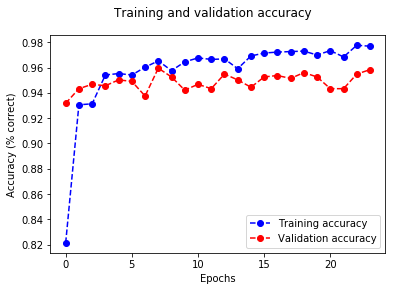

In [206]:
fig = bn.plot_accuracy(training)


In [207]:
p = model.predict(data_test, batch_size=5)
p_idx = np.argmax(p, axis=-1)
p_bundles = np.array([bundle_names[ii] for ii in p_idx])
loaded_from_file = np.load('./subject1_bundles.npz')
labels_test = loaded_from_file['labels_test']
actual_labels = np.array([bundle_names[ii] for ii in (labels_test - 1).astype(int)])
print("Percent correct is %s " % np.mean(p_bundles == actual_labels))

kappa = cohen_kappa_score(p_bundles, actual_labels)
print("Kappa is: %s" % kappa)
jaccard = jaccard_similarity_score(p_bundles, actual_labels)
print("Jaccard is: %s" % jaccard)

Percent correct is 0.9502314814814815 
Kappa is: 0.9483173076923077
Jaccard is: 0.9502314814814815


In [208]:
confusion = np.zeros((len(bundle_names), len(bundle_names)))
arr_bundle_names = np.array(bundle_names)
for xx in range(len(p_bundles)):
    idx1 = np.where(arr_bundle_names == p_bundles[xx])
    idx2 = np.where(arr_bundle_names == actual_labels[xx])
    n = np.sum(actual_labels == actual_labels[xx])
    confusion[idx1, idx2] += 1 / n

In [209]:
sort_idx = np.argsort(arr_bundle_names)

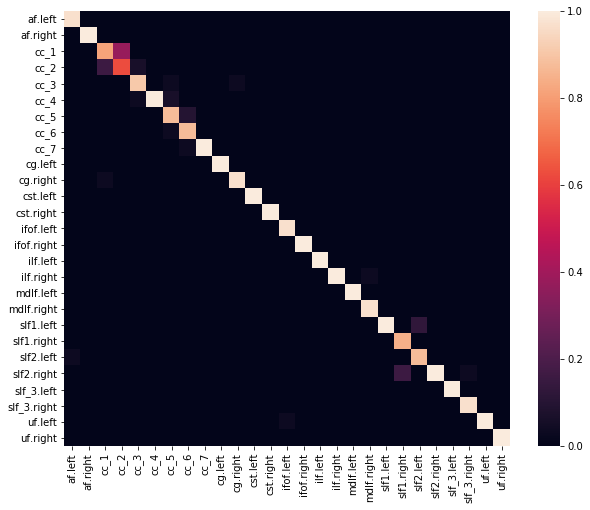

In [210]:
fig, ax = plt.subplots(1)
sns.heatmap(confusion[sort_idx][:, sort_idx],
            xticklabels=arr_bundle_names[sort_idx], 
            yticklabels=arr_bundle_names[sort_idx], ax=ax)
fig.set_size_inches([10, 8])

Cross-predict on *another subject*

In [211]:
sub2_bundle_files = glob('/Users/jpowen/.dipy/exp_bundles_and_maps/bundles_2_subjects/subj_2/bundles/*.trk')

In [212]:
sub2_t1_img = nib.load('/Users/jpowen/.dipy/exp_bundles_and_maps/bundles_2_subjects/subj_2/t1_warped.nii.gz')

In [213]:
n_streamlines = 0
for fname in sub2_bundle_files:
    streamlines = bn.read_sl(fname)
    n_streamlines += len(streamlines)

In [214]:
n_streamlines

57060

In [215]:
if not op.exists('./subject2_bundles_all.npz'):
    data_sub2 = np.zeros((n_streamlines, 100, 100, 1))
    actual_labels = np.zeros(n_streamlines, dtype=np.object)
    ii = 0
    for fname in sub2_bundle_files:
        bundle_name = fname.split('/')[-1].split('bundles_')[-1].split('.trk')[0]
        print(bundle_name)
        streamlines = bn.read_sl(fname)
        for sl in streamlines: 
            data_sub2[ii] = bn.reduce_sl(sl, t1_img.shape)
            if not np.mod(ii, 100):
                print("ii = %s"%ii)
            actual_labels[ii] = bundle_name
            ii += 1

    np.savez('./subject2_bundles_all', data_sub2=data_sub2, actual_labels=actual_labels)
else: 
    from_file = np.load('./subject2_bundles_all.npz')
    data_sub2 = from_file['data_sub2']
    actual_labels = from_file['actual_labels']

cc_6


/anaconda2/envs/bundlenet/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/anaconda2/envs/bundlenet/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


ii = 0
ii = 100
ii = 200
ii = 300
ii = 400
ii = 500
ii = 600
ii = 700
ii = 800
ii = 900
ii = 1000
ii = 1100
ii = 1200
ii = 1300
ii = 1400
ii = 1500
ii = 1600
ii = 1700
ii = 1800
ii = 1900
ii = 2000
ii = 2100
ii = 2200
ii = 2300
ii = 2400
ii = 2500
ii = 2600
ii = 2700
ii = 2800
ii = 2900
ii = 3000
ii = 3100
ii = 3200
ii = 3300
ii = 3400
ii = 3500
ii = 3600
ii = 3700
ii = 3800
ii = 3900
ii = 4000
ii = 4100
ii = 4200
ii = 4300
ii = 4400
ii = 4500
ii = 4600
ii = 4700
ii = 4800
ii = 4900
ii = 5000
ii = 5100
ii = 5200
ii = 5300
ii = 5400
ii = 5500
ii = 5600
ii = 5700
ii = 5800
ii = 5900
ii = 6000
ii = 6100
ii = 6200
ii = 6300
ii = 6400
ii = 6500
ii = 6600
ii = 6700
ii = 6800
ii = 6900
ii = 7000
ii = 7100
ii = 7200
ii = 7300
ii = 7400
ii = 7500
ii = 7600
ii = 7700
ii = 7800
ii = 7900
ii = 8000
ii = 8100
ii = 8200
ii = 8300
ii = 8400
ii = 8500
ii = 8600
ii = 8700
ii = 8800
ii = 8900
ii = 9000
ii = 9100
ii = 9200
cst.left
ii = 9300
ii = 9400
ii = 9500
ii = 9600
ii = 9700
ii = 9800
ii = 9900
ii 

In [216]:
p = model.predict(data_sub2, batch_size=5)

In [217]:
p_idx = np.argmax(p, axis=-1)

In [218]:
p_bundles = [bundle_names[ii] for ii in p_idx]

In [219]:
from sklearn.metrics import cohen_kappa_score, jaccard_similarity_score

In [220]:
print("Percent correct is %s " % np.mean(p_bundles == actual_labels))
kappa = cohen_kappa_score(p_bundles, actual_labels)
print("Kappa is: %s" % kappa)
jaccard = jaccard_similarity_score(p_bundles, actual_labels)
print("Jaccard is: %s" % jaccard)

Percent correct is 0.893901156677182 
Kappa is: 0.8782138513827866
Jaccard is: 0.893901156677182


In [221]:
np.mean(p_bundles == actual_labels)

0.893901156677182

In [222]:
confusion = np.zeros((len(bundle_names), len(bundle_names)))
arr_bundle_names = np.array(bundle_names)
for xx in range(len(p_bundles)):
    idx1 = np.where(arr_bundle_names == p_bundles[xx])
    idx2 = np.where(arr_bundle_names == actual_labels[xx])
    n = np.sum(actual_labels == actual_labels[xx])
    confusion[idx1, idx2] += 1 / n

In [165]:
sort_idx = np.argsort(arr_bundle_names)

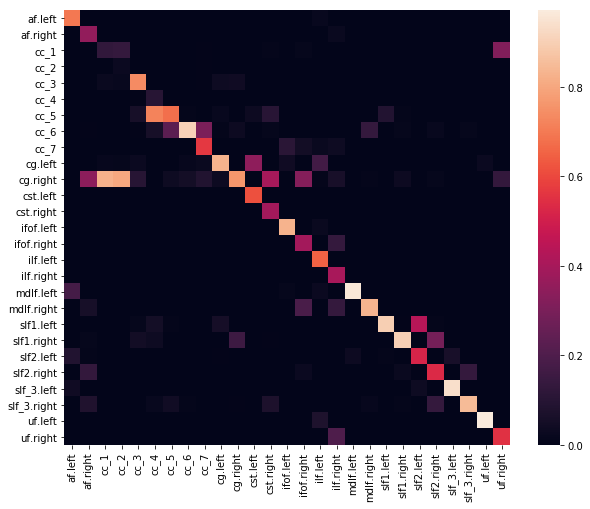

In [169]:
fig, ax = plt.subplots(1)
sns.heatmap(confusion[sort_idx][:, sort_idx],
            xticklabels=arr_bundle_names[sort_idx], 
            yticklabels=arr_bundle_names[sort_idx], ax=ax)
fig.set_size_inches([10, 8])

In [170]:
p_error = p[~(p_bundles == actual_labels)]
p_correct = p[p_bundles == actual_labels]

/anaconda2/envs/bundlenet/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


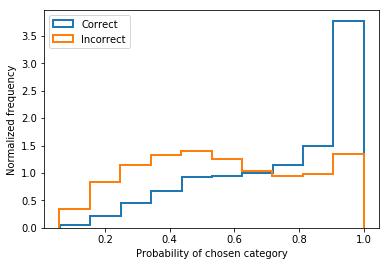

In [171]:
fig, ax = plt.subplots(1)
ax.hist(np.max(p_correct, -1), histtype='step', linewidth=2, normed=True, bins=10, label="Correct")
ax.hist(np.max(p_error, -1), histtype='step', linewidth=2, normed=True, bins=10, label="Incorrect")
ax.set_xlabel("Probability of chosen category")
ax.set_ylabel("Normalized frequency")
plt.legend(loc="upper left")